In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Input , Rescaling , BatchNormalization , Dropout , Conv2D , MaxPooling2D , GlobalAveragePooling2D , Flatten
from keras.initializers import HeNormal , GlorotUniform
from keras.callbacks import EarlyStopping
from keras.preprocessing import image_dataset_from_directory
from keras.optimizers import Adam , AdamW
from keras.regularizers import l1_l2 , l2 , l1
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input , decode_predictions

2025-11-17 14:43:54.252283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763390634.693893      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763390634.801710      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train_data = image_dataset_from_directory(
    '/kaggle/input/car-and-some-random-image/carornot',
    image_size = (224,224),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    validation_split = 0.2,
    subset = 'training',
    seed = 42
)
test_data = image_dataset_from_directory(
    '/kaggle/input/car-and-some-random-image/carornot',
    image_size = (224,224),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42
)

Found 46248 files belonging to 2 classes.
Using 36999 files for training.


I0000 00:00:1763390709.479896      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763390709.480553      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 46248 files belonging to 2 classes.
Using 9249 files for validation.


In [3]:
for image , label in train_data.take(1):
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


In [4]:
class_name = train_data.class_names
class_name

['car', 'not_car']

In [5]:
print(train_data.class_names)
print(test_data.class_names)

['car', 'not_car']
['car', 'not_car']


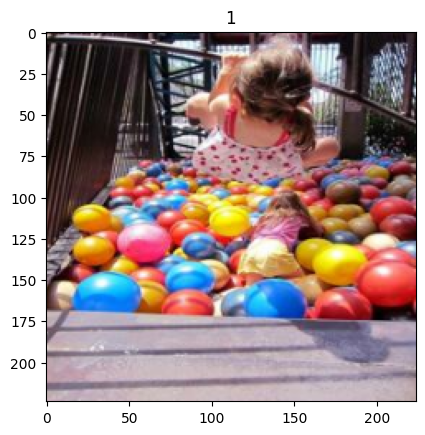

In [6]:
for image , labels in train_data.take(1):
    img = image[0].numpy().astype("uint8")
    plt.imshow(img)
    plt.title(labels[0].numpy())
    plt.show()
    

In [7]:
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label
train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

In [8]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [9]:
efficientNet = EfficientNetB0(weights = 'imagenet' , include_top = False , input_shape = (224 , 224 , 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
efficientNet.trainable = False

In [11]:
model = Sequential()

model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(128 , activation = 'relu' , kernel_initializer = HeNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64 , activation = 'relu' , kernel_initializer = HeNormal()))
model.add(Dense(1 , activation = 'sigmoid'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,372 (16.11 MB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [13]:
model.compile(loss = 'binary_crossentropy' , optimizer = Adam(learning_rate = 3e-4) , metrics = ['accuracy'])

In [14]:
callback = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    restore_best_weights = True ,
    verbose = 1,
    patience = 5 ,
    mode = 'auto'
)

In [15]:
history = model.fit(train_data , epochs = 20 , validation_data = test_data , callbacks = callback)

Epoch 1/20


I0000 00:00:1763390752.804747     118 service.cc:148] XLA service 0x79146800cf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763390752.806712     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763390752.806739     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763390754.936345     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1157 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5747 - loss: 0.8543   

I0000 00:00:1763390765.472621     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1157/1157 ━━━━━━━━━━━━━━━━━━━━ 143s 104ms/step - accuracy: 0.9715 - loss: 0.0791 - val_accuracy: 0.9946 - val_loss: 0.0194
Epoch 2/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - accuracy: 0.9925 - loss: 0.0225 - val_accuracy: 0.9955 - val_loss: 0.0178
Epoch 3/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9946 - loss: 0.0174 - val_accuracy: 0.9950 - val_loss: 0.0182
Epoch 4/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9953 - loss: 0.0147 - val_accuracy: 0.9955 - val_loss: 0.0164
Epoch 5/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9946 - val_loss: 0.0183
Epoch 6/20
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.9965 - loss: 0.0102 - val_accuracy: 0.9952 - val_loss: 0.0176
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [16]:
loss , accuracy = model.evaluate(test_data)
print(f"Accuracy: {accuracy:.4f}")

290/290 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9941 - loss: 0.0229
Accuracy: 0.9946


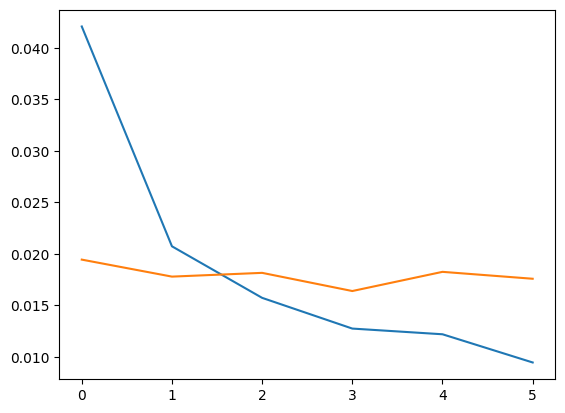

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

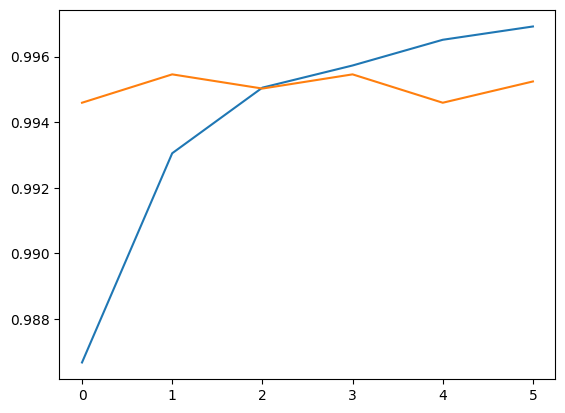

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [19]:
model.save('Model_CarOrNot.keras')